In [1]:
import numpy as np, itertools
import tools21cm as t2c, numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from PIL import Image
from scipy import special
from tqdm import tqdm
from ipywidgets import interact

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-05 10:57:04.384275: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 10:57:04.624117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 10:57:04.624222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 10:57:04.665218: E external/local

## The Fourier Transform of an Image

The Fourier transform takes a function or signal in the time domain and represents it in the frequency domain. This transformation allows us to analyze the frequency content (fourier modes) of the original signal, revealing how much of each frequency component contributes to the overall signal.

Let assume we have an image of the Carina Nebula image from the Hubble Telescope as shown here below. We start by displaying the images in the _spatial domain_.

<img src="images/hs-2010-13-g-small_web.jpg" alt="Drawing" style="width: 300px;"/>

Let apply a 2D Fourier transform and analyse the Fourier space.

In [2]:
img = Image.open('images/hs-2010-13-g-small_web.jpg')

# get only fist color channel
data = np.array(img)[...,0]

# calculate the 2D fourier transform
fft_data = np.fft.fft2(data)

# calculate fourier frequency and define a radial distance
freq_x = np.fft.fftfreq(data.shape[0], 1./data.shape[0])[...,None]
freq_y = np.fft.fftfreq(data.shape[1], 1./data.shape[1])[None, ...]

The _frequency domain_ represents the decomposition of a spatial domain signal into complex sinusoidal waves and this can be achieved via Fourier Transformation

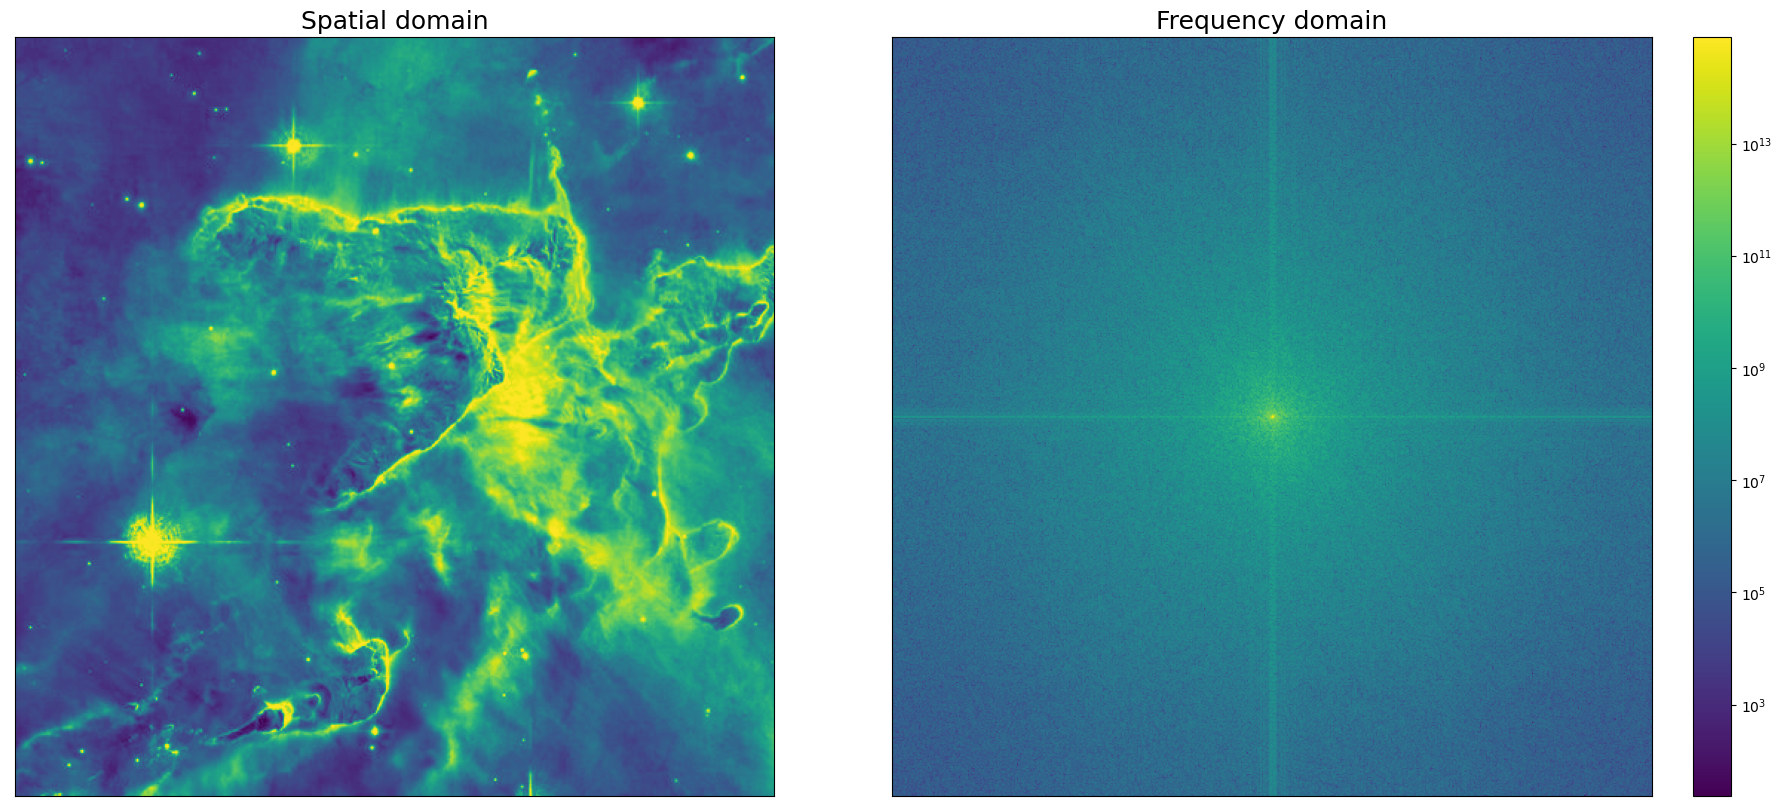

In [3]:
fig, axs = plt.subplots(figsize=(18,8), ncols=2, nrows=1, constrained_layout=True)
axs[0].set_title('Spatial domain', size=18)
im = axs[0].imshow(data)

axs[1].set_title('Frequency domain', size=18)
im = axs[1].imshow(np.fft.fftshift(np.abs(fft_data)**2), norm=LogNorm())
plt.colorbar(im, ax=axs[1], fraction=0.05)
for ax in axs: ax.set_yticks([]), ax.set_xticks([])

Now let play around with the Fourier Transform of the image and remove some fourier-modes.

In [4]:
def plot_uvcut(cut, freq_x0, freq_y0):
    freq_r = np.sqrt((freq_x - freq_x0)**2 + (freq_y - freq_y0)**2)

    # define which spherical modes to remove
    mask = np.where(freq_r < cut, 1, 0)
    
    # remove fourier-modes
    mask_fft_data = fft_data * mask
    
    cut_img = np.fft.ifft2(mask_fft_data).real
    
    
    fig, axs = plt.subplots(figsize=(18,8), ncols=3, nrows=1, constrained_layout=True)
    axs[0].set_title('Residual image', size=18)
    im = axs[0].imshow(data-cut_img, cmap='bwr', vmin=-150, vmax=150)
    plt.colorbar(im, ax=axs[0], fraction=0.05)
    
    axs[1].set_title('Reconstructed image', size=18)
    im = axs[1].imshow(cut_img)
    
    axs[2].set_title('Fourier space', size=18)
    im = axs[2].imshow(np.fft.fftshift(np.abs(mask_fft_data)**2), norm=LogNorm())
    plt.colorbar(im, ax=axs[2], fraction=0.05)
    for ax in axs: ax.set_yticks([]), ax.set_xticks([])

interact(plot_uvcut, cut=(1e-3, 256), freq_x0=(-128, 128), freq_y0=(-128, 128))

interactive(children=(FloatSlider(value=128.0005, description='cut', max=256.0, min=0.001), IntSlider(value=0,…

<function __main__.plot_uvcut(cut, freq_x0, freq_y0)>

## Example incomplete Fourier space

This is important for later but let's select randomly a few values from the frequency domain and reconstruct the image with those few samples. To do a full reconstruction of the image we do an inverse 2D Fourier transform and we look at the residual image, due to the incomplete sampling.

In [6]:
#np.random.seed(2024)
size = 200
freq_x0 = np.random.uniform(-256, 256, size)
freq_y0 = np.random.uniform(-256, 256, size)

mask = np.zeros_like(data).astype(int)
cut = 5
for fx0, fy0 in zip(freq_x0, freq_y0):
    freq_r = np.sqrt((freq_x - fx0)**2 + (freq_y - fy0)**2)
    mask += np.where(freq_r < cut, 1, 0)

# remove fourier-modes
mask_fft_data = fft_data * mask

cut_img = np.fft.ifft2(mask_fft_data).real

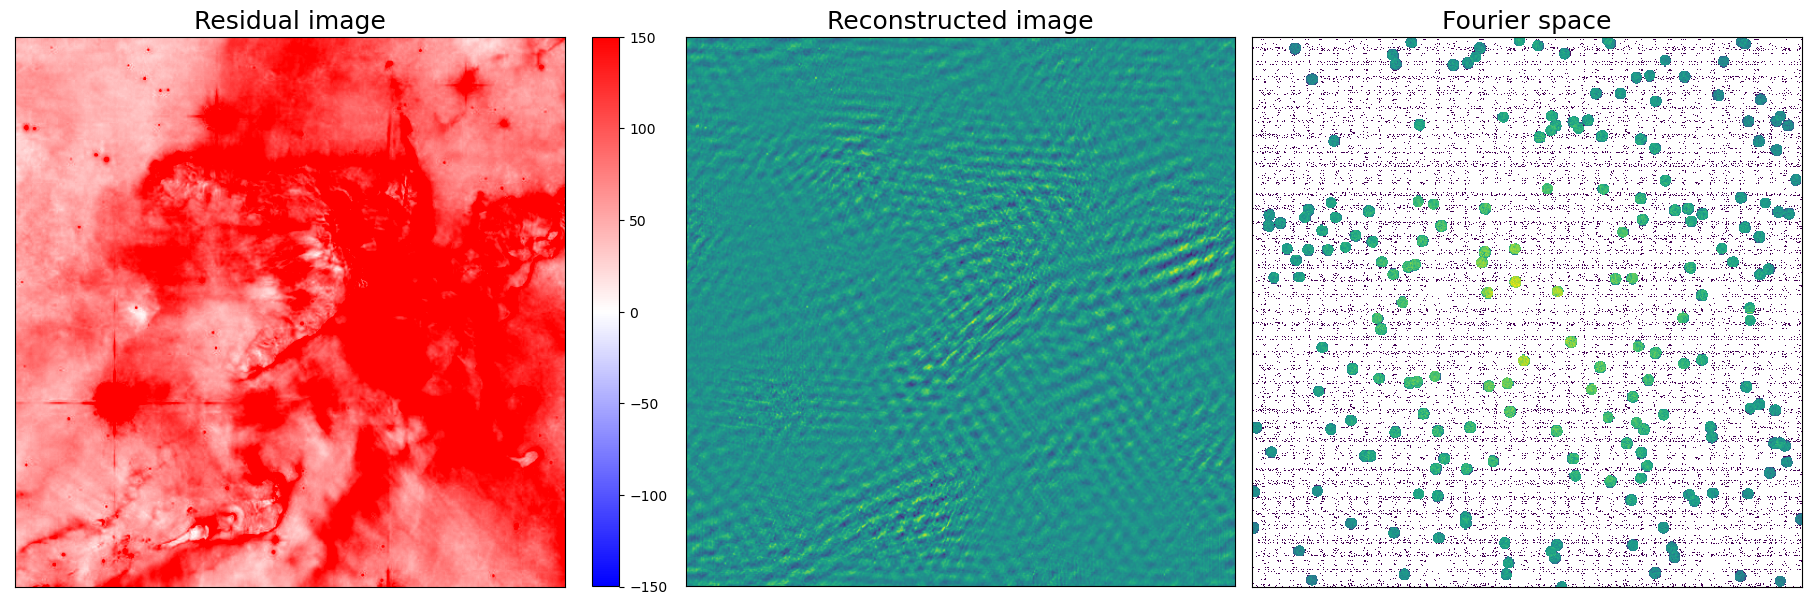

In [7]:
fig, axs = plt.subplots(figsize=(18,8), ncols=3, nrows=1, constrained_layout=True)
axs[0].set_title('Residual image', size=18)
im = axs[0].imshow(data-cut_img, cmap='bwr', vmin=-150, vmax=150)
plt.colorbar(im, ax=axs[0], fraction=0.05)

axs[1].set_title('Reconstructed image', size=18)
im = axs[1].imshow(cut_img)

axs[2].set_title('Fourier space', size=18)
im = axs[2].imshow(np.fft.fftshift(np.abs(mask_fft_data)**2), norm=LogNorm())
#plt.colorbar(im, ax=axs[2], fraction=0.05)
for ax in axs: ax.set_yticks([]), ax.set_xticks([])